## **GAN with MNIST Dataset**

**Imports**

In [2]:
import tensorflow as tf
import tensorflow_datasets as tfds
import numpy as np
import matplotlib.pyplot as plt
import plotly.graph_objects as go
from IPython import display
from tqdm import tqdm
import glob
import imageio.v2 as imageio
import os
from google.colab import drive

**Parameters**

In [3]:
epochs=100
z_dim=64
batch_size=128
buffer_size=1024
AUTOTUNE=tf.data.AUTOTUNE

**Load and Preprocess the Dataset**

In [4]:
train_dataset, info = tfds.load("mnist", split=tfds.Split.TRAIN, as_supervised=True, with_info=True)
info

tfds.core.DatasetInfo(
    name='mnist',
    full_name='mnist/3.0.1',
    description="""
    The MNIST database of handwritten digits.
    """,
    homepage='http://yann.lecun.com/exdb/mnist/',
    data_dir='/root/tensorflow_datasets/mnist/3.0.1',
    file_format=tfrecord,
    download_size=11.06 MiB,
    dataset_size=21.00 MiB,
    features=FeaturesDict({
        'image': Image(shape=(28, 28, 1), dtype=uint8),
        'label': ClassLabel(shape=(), dtype=int64, num_classes=10),
    }),
    supervised_keys=('image', 'label'),
    disable_shuffling=False,
    splits={
        'test': <SplitInfo num_examples=10000, num_shards=1>,
        'train': <SplitInfo num_examples=60000, num_shards=1>,
    },
    citation="""@article{lecun2010mnist,
      title={MNIST handwritten digit database},
      author={LeCun, Yann and Cortes, Corinna and Burges, CJ},
      journal={ATT Labs [Online]. Available: http://yann.lecun.com/exdb/mnist},
      volume={2},
      year={2010}
    }""",
)

In [5]:
def preprocessing(image, label):
  image = tf.cast(image, dtype=tf.float32)/255
  return image

In [6]:
train_dataset = (train_dataset
                 .map(preprocessing)
                 .shuffle(buffer_size, seed=123)
                 .batch(batch_size)
                 .prefetch(AUTOTUNE))

In [7]:
for im in train_dataset.take(1):
  print(im.shape)

(128, 28, 28, 1)


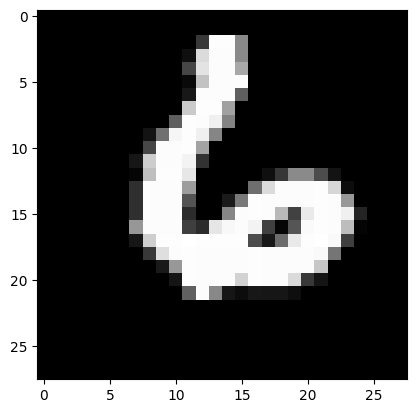

In [8]:
plt.imshow(im[0], cmap="gray");

**Utilities**

In [9]:
drive.mount("/content/drive/")

Mounted at /content/drive/


In [9]:
# Images directory
directory_images = "/content/drive/MyDrive/images"
directory_mnist = os.path.join(directory_images, "mnist_gan")

os.makedirs(directory_mnist, exist_ok=True)

In [10]:
# Display functions

def make_grid(images, num_examples, nrow):
  images=tf.unstack(images[:num_examples], axis=0)
  images=tf.concat(images, axis=1)
  images=tf.split(images, nrow, axis=1)
  images=tf.concat(images, axis=0)

  return images

def show_and_save_images(real_images, fake_images, epoch, num_examples=25, nrow=5):

  real_images = make_grid(real_images, num_examples, nrow)
  fake_images = make_grid(fake_images, num_examples, nrow)

  fig, ax = plt.subplots(1, 2, figsize=(nrow*2, nrow*2))
  ax[0].imshow(fake_images, cmap="gray")
  ax[0].axis("off")
  ax[0].set_title("Generated Images")

  ax[1].imshow(real_images, cmap="gray")
  ax[1].axis("off")
  ax[1].set_title("Real Images")

  plt.show()

  # Save fake images
  plt.imshow(fake_images, cmap="gray")
  plt.axis("off")
  plt.savefig(os.path.join(directory_mnist, f"image{epoch:03d}.png"), transparent=True)
  plt.close()

**Build the Model**


**Custom Model with a custom class (Sequential API):**
```
class Generator(tf.keras.Model):

  def __init__(self, im_dim=784, hidden_dim=128):
    super().__init__()

    self.generator = tf.keras.Sequential([
        self.generator_block(hidden_dim),
        self.generator_block(hidden_dim*2),
        self.generator_block(hidden_dim*4),
        self.generator_block(hidden_dim*8),
        tf.keras.layers.Dense(im_dim, activation="sigmoid")
    ])

  def generator_block(self, units):
    return tf.keras.Sequential([
        tf.keras.layers.Dense(units),
        tf.keras.layers.BatchNormalization(),
        tf.keras.layers.ReLU()
    ])
    return model_block

  def call(self, noise):
    return self.generator(noise)

generator=Generator()
generator.build((None, z_dim))
generator.summary()
```

In [11]:
tf.keras.backend.clear_session()

In [12]:
def model_generator(z_dim=z_dim, hidden_dim=128):
  model=tf.keras.Sequential([
      tf.keras.Input(shape=(z_dim, ))
  ], name="generator")

  for i in range(0, 4):
    model.add(tf.keras.layers.Dense(hidden_dim * 2**i))
    model.add(tf.keras.layers.BatchNormalization())
    model.add(tf.keras.layers.ReLU())

  model.add(tf.keras.layers.Dense(28*28, activation="sigmoid"))
  model.add(tf.keras.layers.Reshape((28, 28)))

  return model

In [13]:
generator=model_generator()
generator.summary()

Model: "generator"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 128)               8320      
                                                                 
 batch_normalization (Batch  (None, 128)               512       
 Normalization)                                                  
                                                                 
 re_lu (ReLU)                (None, 128)               0         
                                                                 
 dense_1 (Dense)             (None, 256)               33024     
                                                                 
 batch_normalization_1 (Bat  (None, 256)               1024      
 chNormalization)                                                
                                                                 
 re_lu_1 (ReLU)              (None, 256)               0 

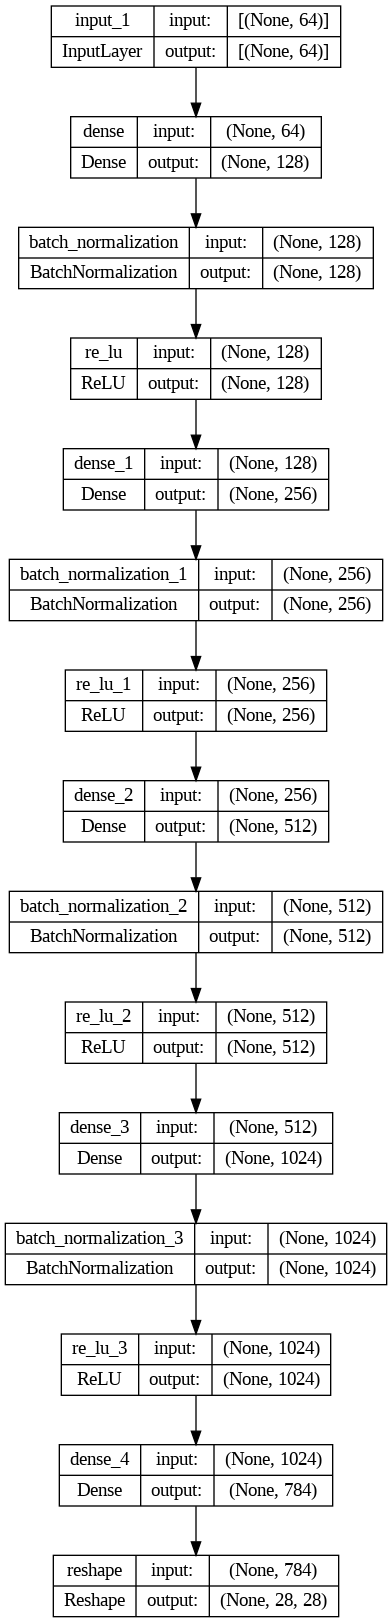

In [15]:
tf.keras.utils.plot_model(generator, show_shapes=True, show_layer_names=True)

In [14]:
def model_discriminator(hidden_dim=128):
  model=tf.keras.Sequential([
      tf.keras.layers.Flatten(input_shape=(28, 28))
  ], name="discriminator")

  for i in range(2, -1, -1):
    model.add(tf.keras.layers.Dense(hidden_dim * 2**i))
    model.add(tf.keras.layers.LeakyReLU(0.2))

  model.add(tf.keras.layers.Dense(1))

  return model

In [15]:
discriminator=model_discriminator()
discriminator.summary()

Model: "discriminator"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 flatten (Flatten)           (None, 784)               0         
                                                                 
 dense_5 (Dense)             (None, 512)               401920    
                                                                 
 leaky_re_lu (LeakyReLU)     (None, 512)               0         
                                                                 
 dense_6 (Dense)             (None, 256)               131328    
                                                                 
 leaky_re_lu_1 (LeakyReLU)   (None, 256)               0         
                                                                 
 dense_7 (Dense)             (None, 128)               32896     
                                                                 
 leaky_re_lu_2 (LeakyReLU)   (None, 128)             

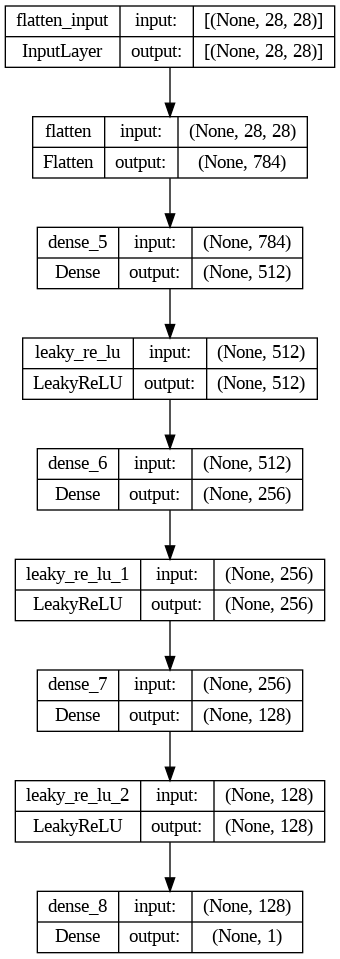

In [18]:
tf.keras.utils.plot_model(discriminator, show_shapes=True, show_layer_names=True)

**Train the Model**

In [16]:
gen_optimizer = tf.keras.optimizers.Adam(learning_rate=1e-5)
disc_optimizer = tf.keras.optimizers.Adam(learning_rate=1e-5)
loss_model = tf.keras.losses.BinaryCrossentropy(from_logits=True)

In [17]:
@tf.function
def train_step(real_images):
  cur_batch_size = len(real_images)
  noise = tf.random.normal(shape=(cur_batch_size, z_dim))

  with tf.GradientTape() as gen_tape, tf.GradientTape() as disc_tape:
    fake_images=generator(noise, training=True)

    real_out = discriminator(real_images, training=True)
    fake_out = discriminator(fake_images, training=True)

    # Generator Loss
    gen_loss = loss_model(tf.ones_like(fake_out), fake_out)

    # Discriminator Loss
    real_loss = loss_model(tf.ones_like(real_out), real_out)
    fake_loss = loss_model(tf.zeros_like(fake_out), fake_out)
    disc_loss = (fake_loss+real_loss) / 2

  gen_gradients = gen_tape.gradient(gen_loss, generator.trainable_variables)
  disc_gradients = disc_tape.gradient(disc_loss, discriminator.trainable_variables)

  gen_optimizer.apply_gradients(zip(gen_gradients, generator.trainable_variables))
  disc_optimizer.apply_gradients(zip(disc_gradients, discriminator.trainable_variables))

  return gen_loss, disc_loss

Generate random images to create the GIF

In [18]:
tf.random.set_seed(123) #for the reproducibility of noise tensor
num_examples = 25
nrow = 5

noise = tf.random.normal((num_examples, z_dim))
fake_images = generator(noise, training=False)

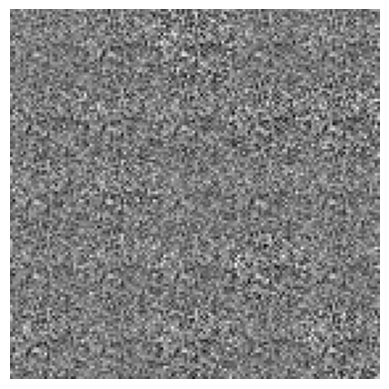

In [19]:
# Epoch 0 image
fake_images = make_grid(fake_images, num_examples, nrow)
plt.imshow(fake_images, cmap="gray")
plt.axis("off")
plt.savefig(os.path.join(directory_mnist, f"image{0:03d}.png"), transparent=True);

In [20]:
# Training function
def train_gan(epochs=epochs, num_examples=num_examples, nrow=nrow):
  history={"gen_loss":[], "disc_loss":[]}

  for epoch in range(epochs):
    gen_loss_list, disc_loss_list = [], []

    with tqdm(train_dataset) as pbar:
      pbar.set_description(f"[Epoch: {epoch+1}/{epochs}]")
      for real_images in pbar:
        gen_loss, disc_loss = train_step(real_images)

        gen_loss_list.append(gen_loss.numpy())
        disc_loss_list.append(disc_loss.numpy())

        pbar.set_postfix({"gen_loss": gen_loss.numpy(), "disc_loss": disc_loss.numpy()})

    gen_loss_mean = np.mean(gen_loss_list)
    disc_loss_mean = np.mean(disc_loss_list)
    history["gen_loss"].append(gen_loss_mean)
    history["disc_loss"].append(disc_loss_mean)

    display.clear_output(wait=False)
    print(f"Epoch {epoch+1}, GeneratorLoss: {gen_loss_mean}, DiscriminatorLoss: {disc_loss_mean}")
    # Examples for training and GIF
    fake_images = generator(noise, training=False)
    show_and_save_images(real_images, fake_images, epoch+1, num_examples, nrow)

  return history

Epoch 100, GeneratorLoss: 1.9628334045410156, DiscriminatorLoss: 0.32970327138900757


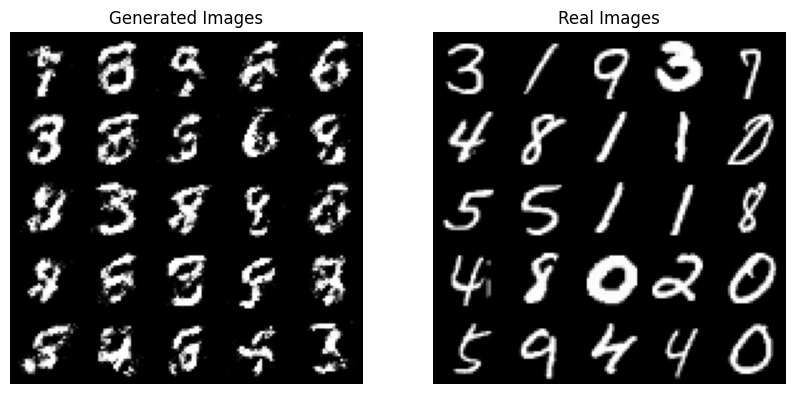

In [21]:
tf.random.set_seed(123)

history = train_gan()

In [22]:
# Function to plot the losses
def plot_metrics(history, renderer=None, epochs = epochs):
  gen_losses=history["gen_loss"]
  disc_losses=history["disc_loss"]
  list_epochs=np.arange(1, epochs+1)

  fig=go.Figure()
  fig.add_trace(go.Scatter(x=list_epochs, y=gen_losses, name="Generator Loss", line=dict(color="blue", width=2)))
  fig.add_trace(go.Scatter(x=list_epochs, y=disc_losses, name="Discriminator Loss", line=dict(color="#FF6600", width=2)))
  fig.update_xaxes(title_text="Epoch")
  fig.update_yaxes(title_text="Loss")
  fig.update_layout(title=f"<b>Evolution of Loss across Epochs</b>",
                    title_font=dict(size=20),
                    title_x=0.5,
                    height=500,
                    width=1200)

  fig.show(renderer)

In [23]:
# Interactive graphic
plot_metrics(history)

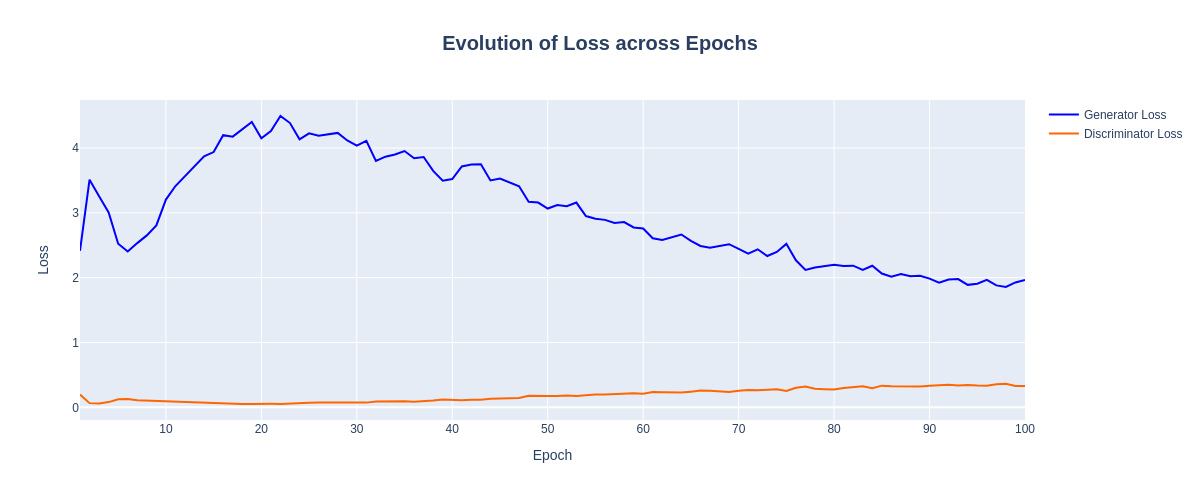

In [24]:
# Image for GitHub
plot_metrics(history, renderer="png")

In [25]:
# Save the generator

generator.save("/content/drive/MyDrive/models/generator_mnist_gan.keras")

**Create a GIF from the generated images**

In [26]:
!pip install tensorflow_docs -q

import tensorflow_docs.vis.embed as embed

In [27]:
# Function to create gifs

def create_gif(gif_file, images_file, fps=1):
  with imageio.get_writer(gif_file, mode="I", loop=0, fps=fps) as writer:
    filenames = sorted(glob.glob(f"{images_file}/*.png"))
    for filename in filenames:
      image = imageio.imread(filename)
      writer.append_data(image)
    image = imageio.imread(filename)
    writer.append_data(image)


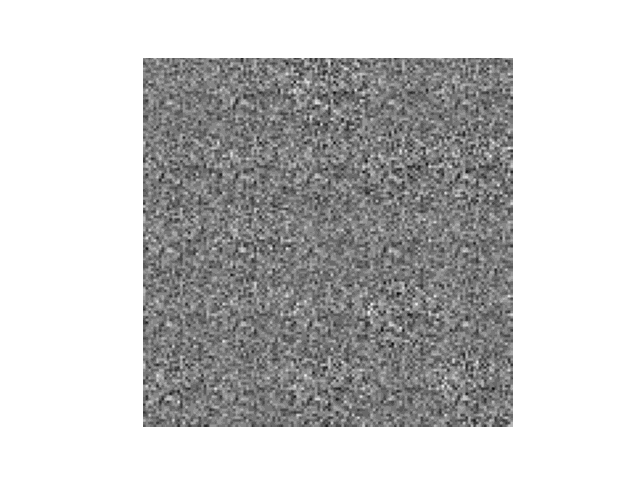

In [32]:
gif_file = os.path.join(directory_mnist, "mnist_gan.gif")
create_gif(gif_file, directory_mnist, fps=7)
embed.embed_file(gif_file)

**Generated Examples**

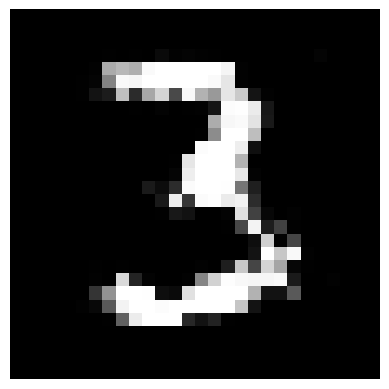

In [51]:
# Generated Example
noise = tf.random.normal(shape=(1, z_dim))
generated_example = generator(noise).numpy().squeeze()
plt.imshow(generated_example, cmap="gray")
plt.axis("off");

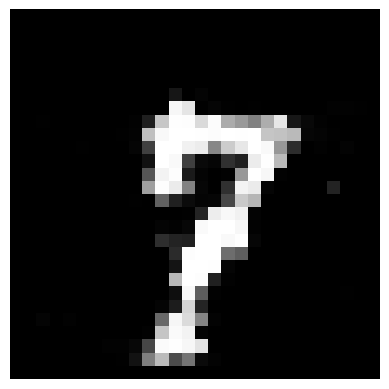

In [34]:
# Generated Example
noise = tf.random.normal(shape=(1, z_dim))
generated_example = generator(noise).numpy().squeeze()
plt.imshow(generated_example, cmap="gray")
plt.axis("off");